In [1]:
using Cxx
using PyCall
using PyPlot
import Images
import StatsBase

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
@pyimport skimage.io as io
disk = morphology.disk;

In [2]:
include("../src/Tracking.jl")

import Tracking
T = Tracking;

In [3]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180329160010.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_p2.mp4"
background_fname = "./4k_p2_background.jpg"

"./4k_p2_background.jpg"

In [4]:
reader = imageio.get_reader(video_file);
# frames = [T.preprocess_frame(reader[:get_data](i)) for i in 1:2:400];

# @time background = T.init_background(frames[1:min(300, size(frames, 1))]; max_iters=3);
# io.imsave(background_fname, background)

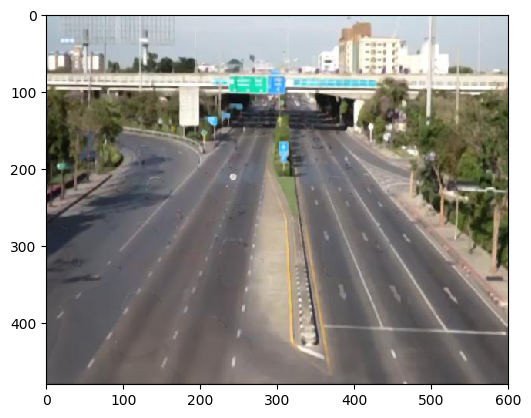

In [5]:
background = io.imread(background_fname) ./ 255;
imshow(background);

In [6]:
threshold = 0.05;

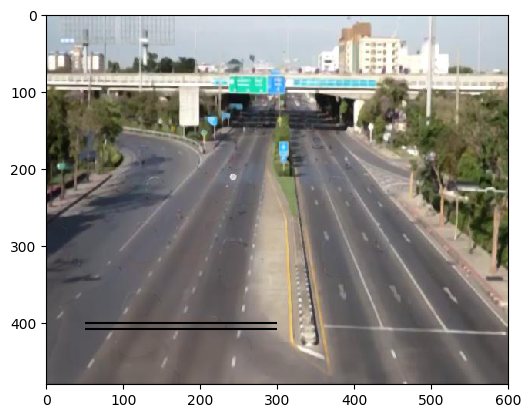

In [7]:
slit_x = 50;
slit_y = 400;
slit_width = 250;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

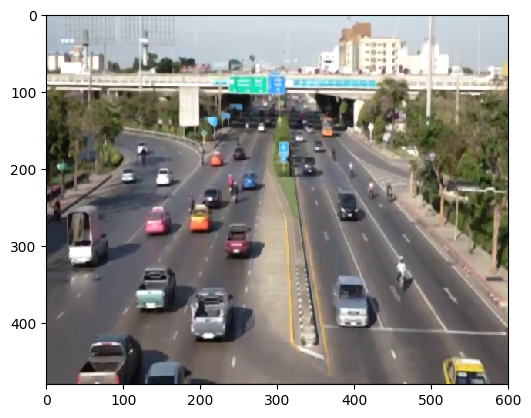

In [8]:
frame = T.preprocess_frame(reader[:get_data](50));
imshow(frame);

In [9]:
adj_threshold = 0.5;
size_threshold = 0.5;

## RGB-ratio model

In [305]:
include("../src/Tracking.jl")

import Tracking
T = Tracking;

foreground = T.subtract_background(frame, background, threshold);

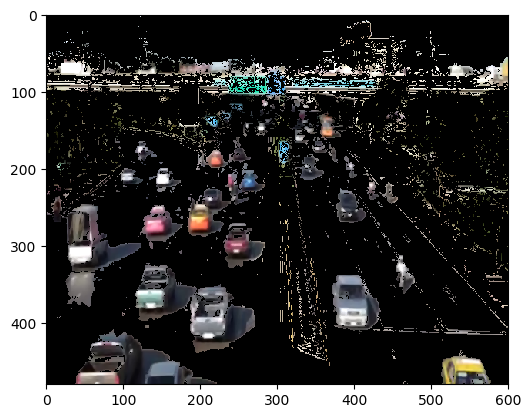

PyObject <matplotlib.image.AxesImage object at 0x7f719a7574a8>

In [307]:
imshow(foreground .* frame)

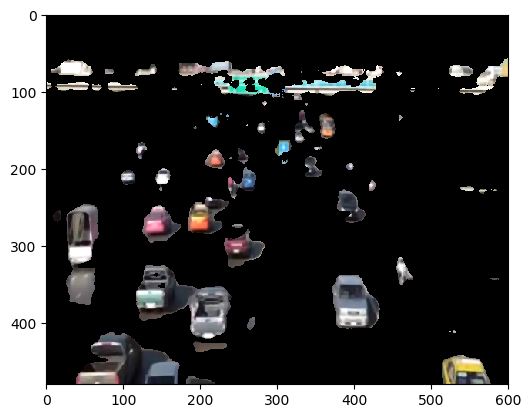

PyObject <matplotlib.image.AxesImage object at 0x7f719a780630>

In [306]:
# foreground2, shadow_labels, pixels_per_bg_label, adj_foreground_ratio = T.suppress_shadows(foreground, frame, background, z_threshold=1.5, adj_threshold=0.3, min_adj_threshold=0.0)
shadow_mask = T.suppress_shadows(foreground, frame, background, z_threshold=1.5, adj_threshold=0.3, min_adj_threshold=0.1)
imshow(shadow_mask .* frame)

### Step by step

In [601]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

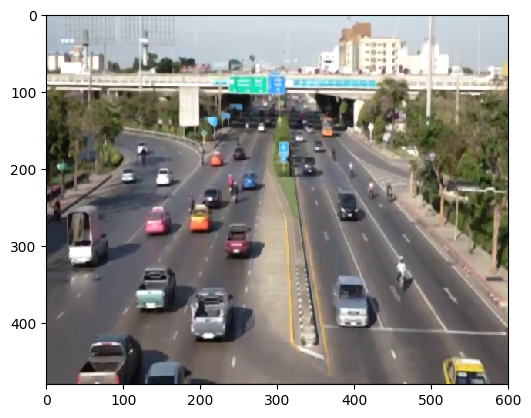

PyObject <matplotlib.image.AxesImage object at 0x7f39807b0f28>

In [798]:
imshow(frame)

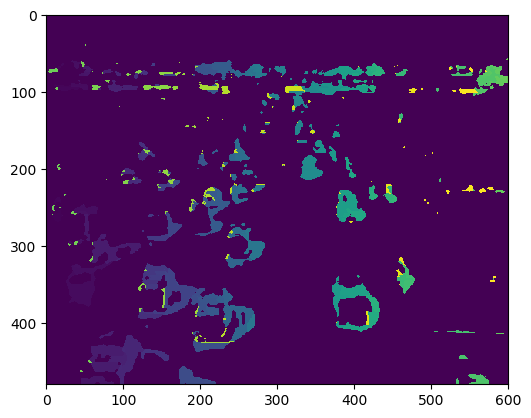

In [816]:
z_threshold = 1.5
adj_threshold = 0.3

d_rows = [0 1 1 1 0 -1 -1 -1]
d_cols = [-1 -1 0 1 1 1 0 -1]

foreground = T.subtract_background(frame, background, threshold);

frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est
shadow_mask_flatten = all(abs.(ratio_score) .< z_threshold, 2);

comp_diffs = [foreground_ratio_pixels[:,i] .- foreground_ratio_pixels[:,j] for (i,j) in [(1,2), (2, 3), (1, 3)]];
shadow_mask_flatten .&= (maximum(abs.(hcat(comp_diffs...)), 2) .< 0.2);

shadow_mask = falses(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_mask_flatten);
shadow_mask = filters.median(shadow_mask, disk(3)) .> 0;
shadow_labels = T.segment_shadows(frame, shadow_mask, edge_threshold=0.05);
n_labels = maximum(shadow_labels)

# imshow(foreground .& .!shadow_mask);

imshow(shadow_labels);

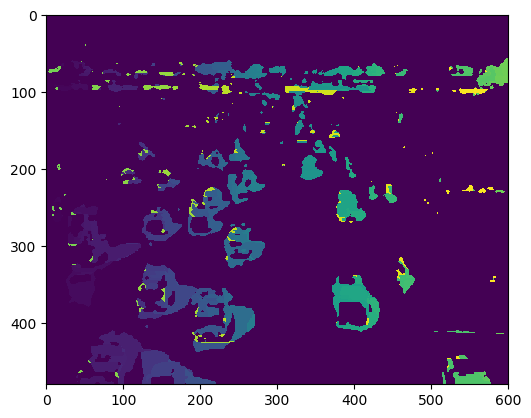

In [794]:
z_threshold = 1.5
adj_threshold = 0.3

d_rows = [0 1 1 1 0 -1 -1 -1]
d_cols = [-1 -1 0 1 1 1 0 -1]

foreground = T.subtract_background(frame, background, threshold);

frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est

comp_diffs = [foreground_ratio_pixels[:,i] .- foreground_ratio_pixels[:,j] for (i,j) in [(1,2), (2, 3), (1, 3)]];
ratio_score .&= maximum(abs.(hcat(comp_diffs...)), 2) .< 0.1;

shadow_mask_flatten = all(abs.(ratio_score) .< z_threshold, 2);
shadow_mask = falses(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_mask_flatten);
shadow_mask = filters.median(shadow_mask, disk(3)) .> 0;
shadow_labels = T.segment_shadows(frame, shadow_mask, edge_threshold=0.05);
n_labels = maximum(shadow_labels)

# imshow(foreground .& .!shadow_mask);

imshow(shadow_labels);

In [592]:
fg_labels = Images.label_components(foreground .& .!shadow_mask) .+ 1;
pixels_per_fg_label = zeros(Int, maximum(fg_labels));
for lab in fg_labels
    pixels_per_fg_label[lab] += 1
end

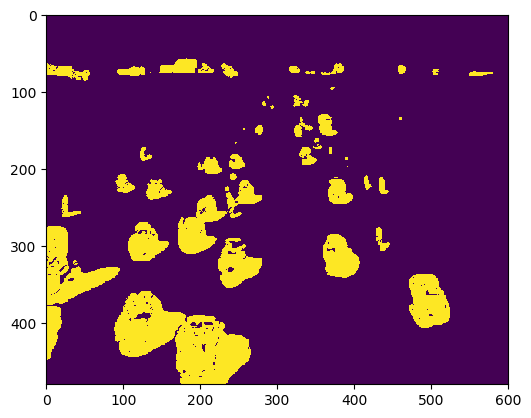

In [593]:
false_fg_mask = (pixels_per_fg_label .< 0.5 * (mean(pixels_per_fg_label[2:end]) + std(pixels_per_fg_label[2:end])))[fg_labels]
foreground[false_fg_mask] = false
imshow(foreground);

In [594]:
border_per_label = zeros(Int, n_labels);
adj_foreground_per_label = zeros(Int, n_labels);

for row in 1:size(frame, 1)
    for col in 1:size(frame, 2)
        const cur_class = shadow_labels[row, col]
        if cur_class == 0
            continue
        end
        
        is_border = false
        for (dr, dc) in zip(d_rows, d_cols)
            row_n = row + dr
            col_n = col + dc
            if row_n < 1 || col_n < 1 || row_n > size(frame, 1) || col_n > size(frame, 2)
                continue
            end
            
            if shadow_labels[row_n, col_n] == cur_class
                continue
            end
            
            if !is_border
                is_border = true
                border_per_label[cur_class] += 1
            end
            
            if foreground[row_n, col_n] && shadow_labels[row_n, col_n] == 0
                adj_foreground_per_label[cur_class] += 1
                break
            end
        end
    end
end

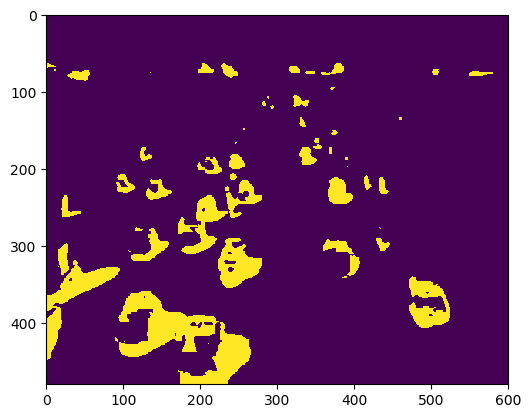

PyObject <matplotlib.image.AxesImage object at 0x7f39828f90f0>

In [595]:
shadow_mask2 = vcat(false, (adj_foreground_per_label ./ border_per_label .< adj_threshold))[shadow_labels .+ 1];
# foreground = filters.median(foreground .& .!shadow_mask, disk(5))
imshow(shadow_mask2)

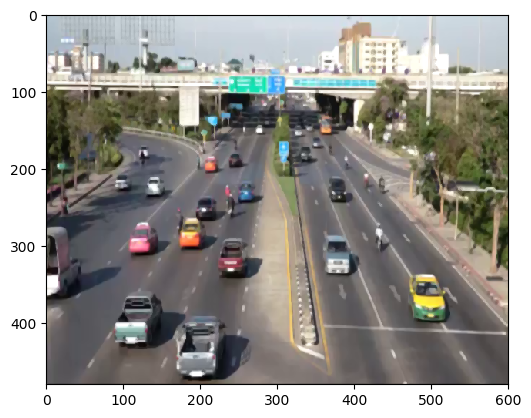

PyObject <matplotlib.image.AxesImage object at 0x7f3982a9acc0>

In [596]:
imshow(frame)

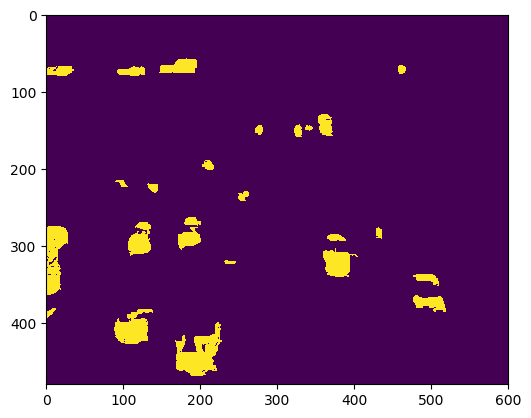

In [597]:
imshow(foreground .& .!shadow_mask2);

## GCO

In [11]:
include("../src/GcWrappers.jl")

import GcWrappers
GW = GcWrappers;

In [12]:
using Distributions

In [62]:
foreground = T.subtract_background(frame, background, threshold);

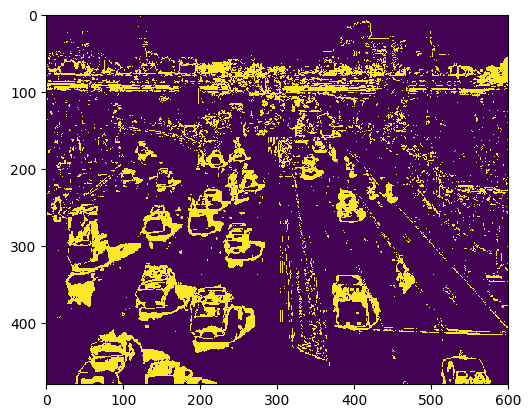

In [14]:
frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est;
# ratio_score = (foreground_ratio_pixels .- 0.4 .* ones(3)') ./ (0.2 .* ones(3)');

shadow_probs = (1 .- cdf.(Normal(), maximum(abs.(ratio_score), 2))) .* 2
shadow_probs = shadow_probs .^ (1 / 3)

shadow_mask = zeros(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_probs);

imshow(shadow_mask .> 0.5);

In [15]:
unary_penalties = hcat(shadow_mask[:], 1 .- shadow_mask[:]);

In [44]:
include("../src/GcWrappers.jl")

import GcWrappers
GW = GcWrappers;

using GCoptimization

height, width = size(shadow_mask)
n_labels = 2

gco = GCoptimizationGeneralGraph(height * width, n_labels)

adj_costs = []
for row in 1:(height - 1)
    for col in 1:(width - 1)
        GW.set_w_neighbors(gco, frame, (row, col), (row + 1, col), height)
        GW.set_w_neighbors(gco, frame, (row, col), (row, col + 1), height)
        GW.set_w_neighbors(gco, frame, (row, col), (row + 1, col + 1), height)
        GW.set_w_neighbors(gco, frame, (row + 1, col), (row, col + 1), height)
        push!(adj_costs, GW.adj_smooth_cost(frame, (row, col), (row + 1, col + 1)))
    end
end

GW.set_data_cost(gco, GW.prob_to_score.(unary_penalties))
GW.set_smooth_cost(gco, 2; penalty=10)

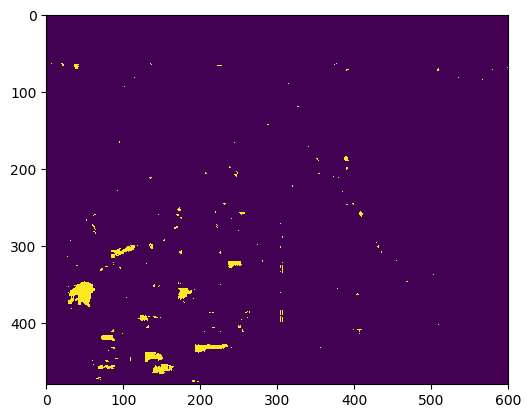

PyObject <matplotlib.image.AxesImage object at 0x7f719cb43ba8>

In [46]:
gco_expansion(gco)
label_ids = 2 .- gco_getlabeling(gco);
shadow_mask2 = reshape(label_ids, size(shadow_mask))

imshow(shadow_mask2)

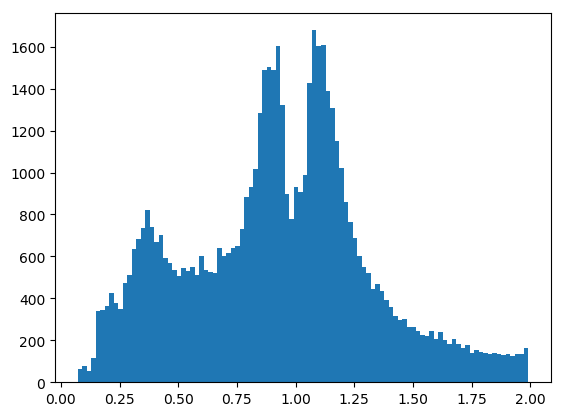

0.9504116222760292

In [69]:
plt[:hist](frame_ratio[:,:,1][foreground][frame_ratio[:,:,1][foreground] .< 2], bins=100);
median(frame_ratio[:,:,3][foreground])

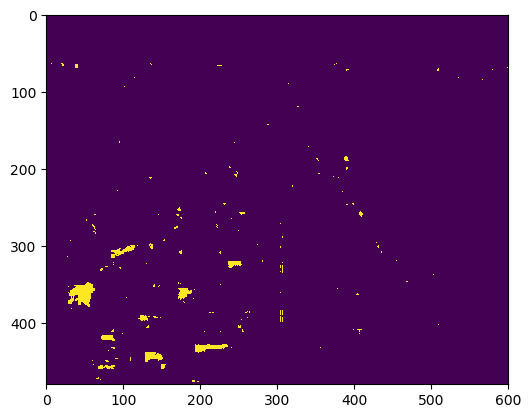

In [49]:
foreground .*= shadow_mask2;

frame_ratio = (frame + 1 / 256) ./ (background + 1 / 256);
foreground_ratio_pixels = hcat([frame_ratio[:,:,i][foreground] for i in 1:3]...);

std_est = mapslices(p -> StatsBase.mad(p; normalize=true), foreground_ratio_pixels, 1);
ratio_score = (foreground_ratio_pixels .- median(foreground_ratio_pixels, 1)) ./ std_est;
# ratio_score = (foreground_ratio_pixels .- 0.4 .* ones(3)') ./ (0.2 .* ones(3)');

shadow_probs = (1 .- cdf.(Normal(), maximum(abs.(ratio_score), 2))) .* 2
shadow_probs = shadow_probs .^ (1 / 3)

shadow_mask = zeros(size(frame)[1:2]);
shadow_mask[foreground] .= vec(shadow_probs);

imshow(shadow_mask .> 0.5);

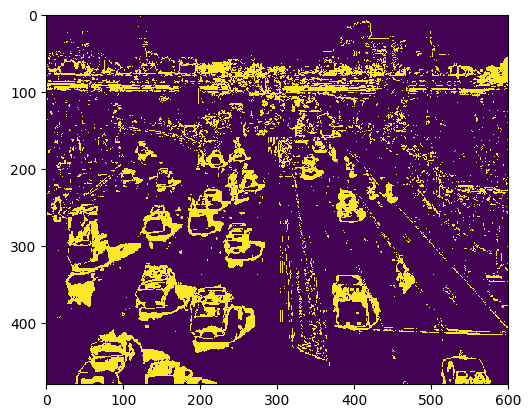

In [18]:
imshow(shadow_mask .> 0.5);